# Generating Lottery Ticket with one shot pruning

In this notebook I will try to generate winning tickets with **one-shot pruning** approach.

We will follow the following steps:

1. Initiate a model, save the initial weights. 

2. Train the model till convergence. That will be the original model.

3. Prune the p% of the weights (prune the low magnitudes).

4. Create a mask for the weights.

5. Train a network manually with initial weights and mask

6. Evaluate the results

### Then additional experiments and comparisons

With:

7. Random initial weights, proper mask

8. Original initial weights, random mask

9. Random weights, random mask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/"My Drive"/"Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 296kB 8.7MB/s 


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
import numpy as np
import math
import os
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, datasets
from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, InputLayer, LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal
from sklearn.metrics import accuracy_score, precision_score, recall_score
from load_MNIST import load_MNIST
from used_func import parameter_count


2.2.0


In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print("\nDimensions of training and testing sets are:")
print("X_train.shape = {0}, y_train = {1}".format(x_train.shape, y_train.shape))
print("X_test.shape = {0}, y_test = {1}".format(x_test.shape, y_test.shape))


Dimensions of training and testing sets are:
X_train.shape = (60000, 28, 28), y_train = (60000,)
X_test.shape = (10000, 28, 28), y_test = (10000,)


In [ ]:
# Specify the parameters to be used for layer-wise pruning, NO PRUNING is done here:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
        end_step = 0, frequency=100
    )
}

In [ ]:
# Specify the parameters to be used for layer-wise pruning
#p=0.2, %30 of the weights will be pruned in this setup
#we are setting begin_step=0 because we will prune the trained model

pruning_params_pruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.3, begin_step=0,
        end_step = -1, frequency=100
    )
}

In [ ]:
def pruned_nn(pruning_params):
    """
    Function to define a 300 100 dense
    fully connected architecture for MNIST
    classification
    """
    pruned_model = Sequential()

    pruned_model.add(
            Input(shape=(28,28)
            )
    )

    
    pruned_model.add(
        sparsity.prune_low_magnitude(
            LSTM(64,
                 activation='relu', 
                 ), 
                 **pruning_params)
    )

    pruned_model.add(
        sparsity.prune_low_magnitude(
            Dense(
                units = 10, activation = 'softmax'
            ),
            **pruning_params)
   )
    
    
    pruned_model.compile(
        loss = tf.keras.losses.sparse_categorical_crossentropy,
        optimizer="adam",
        metrics = ['accuracy'])

    return pruned_model



In [ ]:
# Add a pruning step callback to peg the pruning step to the optimizer's 
# step. Also add a callback to add pruning summaries to tensorboard

callbacks = [
             sparsity.UpdatePruningStep(),
             # sparsity.PruningSummaries(log_dir = logdir, profile_batch=0),
             tf.keras.callbacks.EarlyStopping(
                 monitor='val_loss', patience = 3,
                 min_delta=0.001
             )
]

## 1: Randomly Initialize the Network

In this step we will randomly initialize and train the network. We will save the initial random weights to use them later on.

In [ ]:
# Instantiate the NN-
orig_model = pruned_nn(pruning_params_unpruned)

Instructions for updating:
Please use `layer.add_weight` method instead.


In [ ]:
# Save random initialized weights BEFORE pruning and training of NN
# and BEFORE the model is STRIPPED-

#first let's create the folder

dirName='ExpLSTM'

if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ")
else:    
    print("Directory " , dirName ,  " already exists")



Directory  ExpLSTM  already exists


In [ ]:
orig_model.save_weights('ExpLSTM/MNIST_300_100_Randomly_Initialized_weights', overwrite=True)

In [ ]:
# Strip the pruning wrappers from UNPRUNED model-
orig_model_stripped = sparsity.strip_pruning(orig_model)

In [ ]:
# Save random uninitialized weights BEFORE pruning of NN using STRIPPED model-
orig_model_stripped.save_weights("ExpLSTM/MNIST_300_100_Original_Weights_Unpruned", overwrite=True)

In [ ]:
orig_model_params=parameter_count('orig_model',orig_model)


In orig_model Number of nonzero parameters in each layer are: 

7168
16384
64
640
0

Total number of trainable parameters = 24256



In [ ]:
orig_model_stripped_params=parameter_count('orig_model_stripped',orig_model_stripped)


In orig_model_stripped Number of nonzero parameters in each layer are: 

7168
16384
64
640
0

Total number of trainable parameters = 24256



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_lstm (Pr (None, 64)                47363     
_________________________________________________________________
prune_low_magnitude_dense (P (None, 10)                1292      
Total params: 48,655
Trainable params: 24,458
Non-trainable params: 24,197
_________________________________________________________________


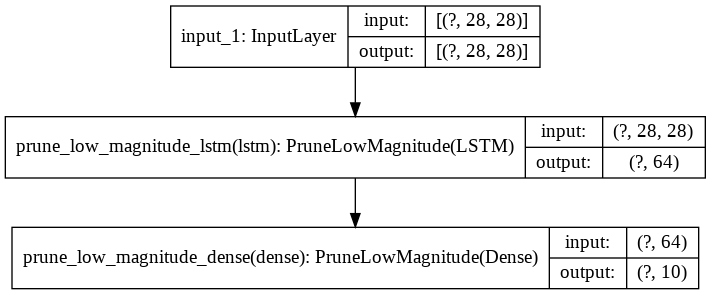

In [ ]:
from tensorflow.keras.utils import  plot_model
orig_model.summary()
plot_model(orig_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
orig_model_stripped.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                23808     
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 24,458
Trainable params: 24,458
Non-trainable params: 0
_________________________________________________________________


### 2: Train the unpruned Network until it converges
_Early Stopping_ criterion has been used for training of the model

This Early Stopping criterion is important to decide on the winning ticket

In [ ]:
# Train unpruned Neural Network-
history_orig = orig_model.fit(
    x = x_train, y = y_train,
    batch_size = 32,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (x_test, y_test),
    shuffle = True
)


Epoch 1/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.5926 - accuracy: 0.8107 - val_loss: 0.2199 - val_accuracy: 0.9300
Epoch 2/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1579 - accuracy: 0.9517 - val_loss: 0.1357 - val_accuracy: 0.9566
Epoch 3/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1133 - accuracy: 0.9657 - val_loss: 0.1223 - val_accuracy: 0.9627
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0846 - accuracy: 0.9741 - val_loss: 0.0738 - val_accuracy: 0.9782
Epoch 5/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0712 - accuracy: 0.9782 - val_loss: 0.0661 - val_accuracy: 0.9790
Epoch 6/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 0.0651 - val_accuracy: 0.9798
Epoch 7/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0527 - accuracy: 0.9837 - val_loss: 0.0459 -

In [ ]:
# Evaluate original unpruned trained model on testing dataset-
score_orig_model = orig_model.evaluate(x_test, y_test, verbose=0)

print("\nOriginal & UNPRUNED model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_orig_model[0], score_orig_model[1]))


Original & UNPRUNED model metrics on testing dataset:
loss = 0.0614 and accuracy = 0.9807



In [ ]:
# Trained parameters of neural network AFTER training UNPRUNED model-
orig_model.save_weights("ExpLSTM/MNIST_300_100_Trained_Weights_Unpruned", overwrite = True)

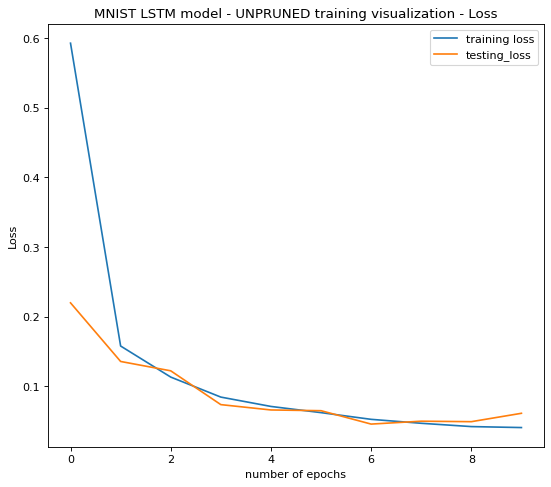

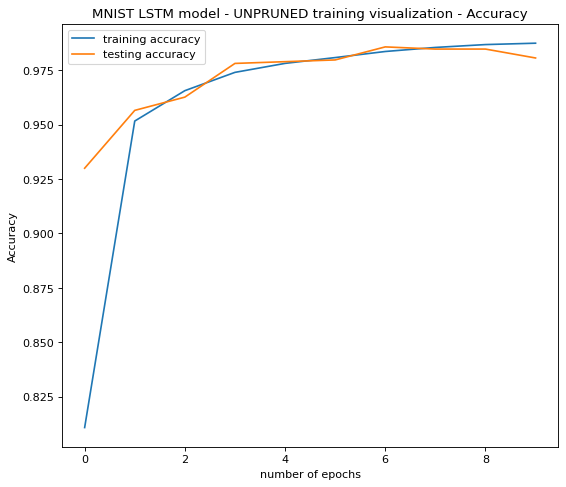

In [ ]:
# Visualize the training of the neural network (scalar metrics):
fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['loss'], label = 'training loss')
plt.plot(history_orig.history['val_loss'], label = 'testing_loss')

plt.title("MNIST LSTM model - UNPRUNED training visualization - Loss")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_orig.history['accuracy'], label = 'training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST LSTM model - UNPRUNED training visualization - Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')  # 'center right'
plt.show()


### Count number of non-zero parameters in each layer-

In [ ]:
orig_model_trained_params=parameter_count('orig_model_trained',orig_model)


In orig_model_trained Number of nonzero parameters in each layer are: 

7168
16384
256
640
10

Total number of trainable parameters = 24458



### Observation

The parameter count is 410 more, because 410 is the number of the hidden units

Beside that we can see that the number of the weigths remained same since there were no pruning

## 3 Pruning the network with one-shot pruning

Here, the trained model will be pruned p% of its weights


In [ ]:
# Instantiate a Nueal Network model to be pruned using parameters from above-
pruned_model = pruned_nn(pruning_params_pruned)

In [ ]:
# Load weights from original trained and unpruned model-
pruned_model.load_weights("ExpLSTM/MNIST_300_100_Trained_Weights_Unpruned")

In [ ]:
# Train pruned NN
history_pruned = pruned_model.fit(
    x = x_train, y = y_train,
    batch_size = 32,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks,
    validation_data = (x_test, y_test),
    shuffle = True
)


Epoch 1/10
1875/1875 [==============================] - 37s 19ms/step - loss: 0.0297 - accuracy: 0.9908 - val_loss: 0.0443 - val_accuracy: 0.9864
Epoch 2/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0258 - accuracy: 0.9916 - val_loss: 0.0456 - val_accuracy: 0.9870
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.0471 - val_accuracy: 0.9868
Epoch 4/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0223 - accuracy: 0.9927 - val_loss: 0.0409 - val_accuracy: 0.9881
Epoch 5/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.0538 - val_accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.0575 - val_accuracy: 0.9856
Epoch 7/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 0.0472 -

In [ ]:
# Evaluate pruned trained model on testing dataset-
score_pruned_model = pruned_model.evaluate(x_test, y_test, verbose = 0)

print("\nPRUNED model metrics on testing dataset:")
print("loss = {0:.4f} and accuracy = {1:.4f}\n".format(score_pruned_model[0], score_pruned_model[1]))


PRUNED model metrics on testing dataset:
loss = 0.0472 and accuracy = 0.9866



In [ ]:
# Save weights of PRUNED and Trained model BEFORE stripping-
pruned_model.save_weights("ExpLSTM/MNIST_300_100_Weights_Pruned_with_pruning_params", overwrite = True)

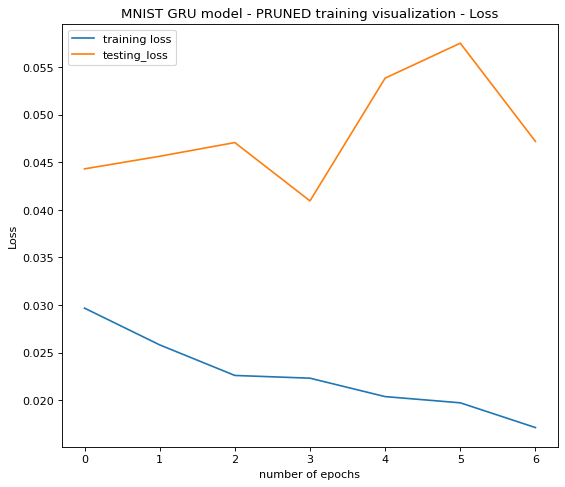

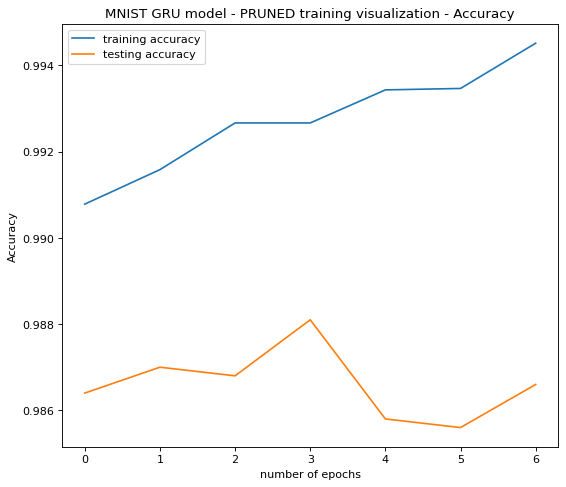

In [ ]:
# Visualize the training of the neural network (scalar metrics):
fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_pruned.history['loss'], label = 'training loss')
plt.plot(history_pruned.history['val_loss'], label = 'testing_loss')

plt.title("MNIST LSTM model - PRUNED training visualization - Loss")
plt.xlabel("number of epochs")
plt.ylabel("Loss")
plt.legend(loc = 'best')
plt.show()

fig=plt.figure(figsize=(8, 7), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_pruned.history['accuracy'], label = 'training accuracy')
plt.plot(history_pruned.history['val_accuracy'], label = 'testing accuracy')

plt.title("MNIST LSTM model - PRUNED training visualization - Accuracy")
plt.xlabel("number of epochs")
plt.ylabel("Accuracy")
plt.legend(loc = 'best')  # 'center right'
plt.show()

In [ ]:
# Strip the pruning wrappers from pruned model-
pruned_model_stripped = sparsity.strip_pruning(pruned_model)

In [ ]:
# Show architecture of model (with pruning parameters)-
pruned_model_stripped.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                23808     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 24,458
Trainable params: 24,458
Non-trainable params: 0
_________________________________________________________________


### THIS IS IMPORTANT!!!

We have to reload the initial weights to the original model. Otherwise it will use the trained ones.

In [ ]:
# we need to load the original weights to the model before we continue

orig_model_stripped.load_weights("ExpLSTM/MNIST_300_100_Original_Weights_Unpruned")

orig_model_stripped_params=parameter_count('orig_model_stripped',orig_model_stripped)


In orig_model_stripped Number of nonzero parameters in each layer are: 

7168
16384
64
640
0

Total number of trainable parameters = 24256



In [ ]:
pruned_model_params=parameter_count('pruned_model',pruned_model)


In pruned_model Number of nonzero parameters in each layer are: 

5018
11469
256
448
10

Total number of trainable parameters = 17201



In [ ]:
# Sanity-check: confirm that p = 30% of the weights are actually pruned away from the network-

#we are subtracting 410 because it is the number of the units in the neural net

print("\n% of weights pruned away = {0:.2f}%\n".format( \
    (orig_model_stripped_params - pruned_model_params- 24458) / orig_model_stripped_params * 100))


% of weights pruned away = -71.75%



## 4: Create mask with pruned weights:

We use pruned model to create a mask

The mask is created as follows-

1. Weights surviving the pruning are set to one (1)
1. Weights which are pruned are set to zero (0)

In [ ]:
# Instantiate a new neural network model for which, the mask is to be created,

mask_model = pruned_nn(pruning_params_unpruned)

In [ ]:
# Load weights of PRUNED model-
mask_model.load_weights("ExpLSTM/MNIST_300_100_Weights_Pruned_with_pruning_params")

In [ ]:
# Strip the model of its pruning parameters-
mask_model_stripped = sparsity.strip_pruning(mask_model)

In [ ]:
# For each layer, for each weight which is 0, leave it, as is.
# And for weights which survive the pruning,reinitialize it to ONE (1)-

for wts in mask_model_stripped.trainable_weights:
    wts.assign(tf.where(tf.equal(wts, 0.), 0., 1.))

In [ ]:
print("\nNetwork architecture of masked model:\n")

for layer in mask_model_stripped.trainable_weights:
    print(layer.shape)


Network architecture of masked model:

(28, 256)
(64, 256)
(256,)
(64, 10)
(10,)


In [ ]:
# Sanity check whether mask is indeed created-

mask_model_stripped.trainable_weights[2]

<tf.Variable 'prune_low_magnitude_lstm_2/lstm_cell_2/bias:0' shape=(256,) dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    

In [ ]:
mask_model_stripped_params=parameter_count('mask_model_stripped',mask_model_stripped)


In mask_model_stripped Number of nonzero parameters in each layer are: 

5018
11469
256
448
10

Total number of trainable parameters = 17201



In [ ]:
#Sanity check, to see again the % of the 0 weights

print("% of weights reduced = {0:.2f}%\n".format(((orig_model_stripped_params - mask_model_stripped_params-24458) / orig_model_stripped_params) * 100))

% of weights reduced = -71.75%



In [ ]:
#sanity check for the masked model and prunned model
#to check if the pruned weights actually set to zero

mask_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
pruned_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.47757655, -0.06546721, -0.13884573,  0.00121218],
      dtype=float32)>

## 5: Train the network with initial weights and created mask to generate winning ticket

We  will reset the remaining parameters in the pruned model to their values in  _Step - 1_ , to generate the winning ticket.

We will leave other weights as zero


In [ ]:
# Instantiate a new neural network model for which, the weights are to be extracted

winning_ticket_model = pruned_nn(pruning_params_unpruned)

In [ ]:
# Load weights of PRUNED model-

winning_ticket_model.load_weights("ExpLSTM/MNIST_300_100_Weights_Pruned_with_pruning_params")

In [ ]:
# Strip the model of its pruning parameters-

winning_ticket_model_stripped = sparsity.strip_pruning(winning_ticket_model)

In [ ]:
# For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
# reinitialize it to the value, the model received BEFORE it was trained and pruned-


for orig_wts, pruned_wts in zip(orig_model_stripped.trainable_weights, winning_ticket_model_stripped.trainable_weights):
    pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, orig_wts))

### Sanity check

To check of the winning tickets parameters are assigned with the original model and pruned model

In [ ]:
# Sanity check
winning_ticket_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.01175799, -0.06234023,  0.00456182,  0.08502214],
      dtype=float32)>

In [ ]:
#again sanity check with the original model

orig_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.03803539,  0.01175799, -0.06234023,  0.00456182,  0.08502214],
      dtype=float32)>

In [ ]:
mask_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
winning_ticket_stripped_params=parameter_count('winning_ticket_model_stripped',winning_ticket_model_stripped)


In winning_ticket_model_stripped Number of nonzero parameters in each layer are: 

5018
11469
64
448
0

Total number of trainable parameters = 16999



In [ ]:
# Sanity check:
# again we are adding 410 for hidden units

if winning_ticket_stripped_params+24458 != pruned_model_params:
    print("\nCritical Error! Number of parameters of winning ticket and pruned parameters do not match!\n")


Critical Error! Number of parameters of winning ticket and pruned parameters do not match!



In [ ]:
# Save the weights (with pruning parameters) extracted to a file-

winning_ticket_model_stripped.save_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_One_Shot", overwrite=True)

## 6: Evaluating the resulting Network

According to the paper, in order to identify a winning ticket:

1. Winning ticket should achieve same or higher accuracy
2. In same or lower epochs

## Using _GradientTape_ API:

### Train _winning ticket_ model to observe it's convergence

In [ ]:
#Instantiate a model-
model_gt = pruned_nn(pruning_params_unpruned)

In [ ]:
model_gt_stripped=sparsity.strip_pruning(model_gt)

In [ ]:
# Load weights of winning ticket-
model_gt_stripped.load_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_One_Shot")

In [ ]:
model_gt.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_lstm_4 ( (None, 64)                47363     
_________________________________________________________________
prune_low_magnitude_dense_4  (None, 10)                1292      
Total params: 48,655
Trainable params: 24,458
Non-trainable params: 24,197
_________________________________________________________________


In [ ]:
model_gt_stripped.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                23808     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 24,458
Trainable params: 24,458
Non-trainable params: 0
_________________________________________________________________


### Sanity check to compare the weights of winning ticket

In [ ]:
#sanity check to compare with the winning ticket weights
model_gt_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.01175799, -0.06234023,  0.00456182,  0.08502214],
      dtype=float32)>

In [ ]:
winning_ticket_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.01175799, -0.06234023,  0.00456182,  0.08502214],
      dtype=float32)>

In [ ]:
# Create training and testing datasets for Tensorflow
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size = 20000, reshuffle_each_iteration = True).batch(batch_size = 32, drop_remainder = False)

test_dataset = test_dataset.batch(batch_size=32, drop_remainder=False)

In [ ]:
# Choose an optimizer and loss function for training-
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Select metrics to measure the error & accuracy of model.
# These metrics accumulate the values over epochs and then
# print the overall result-
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

### Identifying the training and test step

In [ ]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    def train_step(data, labels):
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    '''
    for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
        # orig_grads.assign(tf.math.multiply(orig_grads, mask))
        orig_grads = tf.math.multiply(orig_grads, mask)
    '''
    
    # THIS IS CORRECT-
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # normally we just apply the grads but here we use masked grads
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    # return model_loss
    # return None


In [ ]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


### Provide parameters for _EarlyStopping_

The parameters should be same with the original model

In [ ]:
minimum_delta = 0.001
patience = 3

patience_val = np.zeros(patience)

In [ ]:
# Dictionary to hold scalar metrics-
history_winning = {}

history_winning['accuracy'] = np.zeros(10)
history_winning['val_accuracy'] = np.zeros(10)
history_winning['loss'] = np.zeros(10)
history_winning['val_loss'] = np.zeros(10)

In [ ]:
#min_loss and patience_sofar is the variables to manually enable early stopping  
min_loss=10
patience_sofar=0

for epoch in range(10):
    
    #to stop training when earlystopping criterion met
    if patience_sofar >= patience:
        print("\n\nEarlyStopping Evoked! Stopping training\n\n")
        break
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_dataset:
        train_one_step(model_gt_stripped, mask_model_stripped, optimizer, x, y)
        

    for x_t, y_t in test_dataset:
        
        test_step(model_gt_stripped, optimizer, x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history_winning['accuracy'][epoch] = train_accuracy.result()
    history_winning['loss'][epoch] = train_loss.result()
    history_winning['val_loss'][epoch] = test_loss.result()
    history_winning['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))
    
    # Count number of non-zero parameters in each layer and in total-

    model_sum_params = 0
    
    for layer in model_gt_stripped.trainable_weights:
        
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    #for computing the early stopping manually
    
    if (min_loss-history_winning['val_loss'][epoch])>minimum_delta:
        min_loss=history_winning['val_loss'][epoch]
    else:
        patience_sofar+=1
    
            

Epoch 1, Loss: 0.4022, Accuracy: 87.2533, Test Loss: 0.1367, Test Accuracy: 95.650002
Total number of trainable parameters = 17201

Epoch 2, Loss: 0.1276, Accuracy: 96.1350, Test Loss: 0.0802, Test Accuracy: 97.570000
Total number of trainable parameters = 17201

Epoch 3, Loss: 0.0917, Accuracy: 97.1567, Test Loss: 0.0787, Test Accuracy: 97.389999
Total number of trainable parameters = 17201

Epoch 4, Loss: 0.0735, Accuracy: 97.7017, Test Loss: 0.0659, Test Accuracy: 97.820000
Total number of trainable parameters = 17201

Epoch 5, Loss: 0.0618, Accuracy: 98.1267, Test Loss: 0.0685, Test Accuracy: 97.860001
Total number of trainable parameters = 17201

Epoch 6, Loss: 0.0521, Accuracy: 98.3667, Test Loss: 0.0532, Test Accuracy: 98.239998
Total number of trainable parameters = 17201

Epoch 7, Loss: 0.0454, Accuracy: 98.6483, Test Loss: 0.0673, Test Accuracy: 97.759995
Total number of trainable parameters = 17201

Epoch 8, Loss: 0.0422, Accuracy: 98.6950, Test Loss: 0.0511, Test Accuracy: 

In [ ]:
#test accuracy of pruned model

score_pruned_model[1]

0.9865999817848206

In [ ]:
#test accuracy of winning ticket

test_accuracy.reset_states()
test_step(model_gt_stripped,optimizer,x_test,y_test)
score_winning=test_accuracy.result()
print(score_winning)

tf.Tensor(0.982, shape=(), dtype=float32)


In [ ]:
#test accuracy of orig model

score_orig_model[1]

0.9807000160217285

In [ ]:
#to clear the zero values from dictionary to have better visualization

for k,v in history_winning.items():
    history_winning[k]=np.where(v==0,np.nan,v)

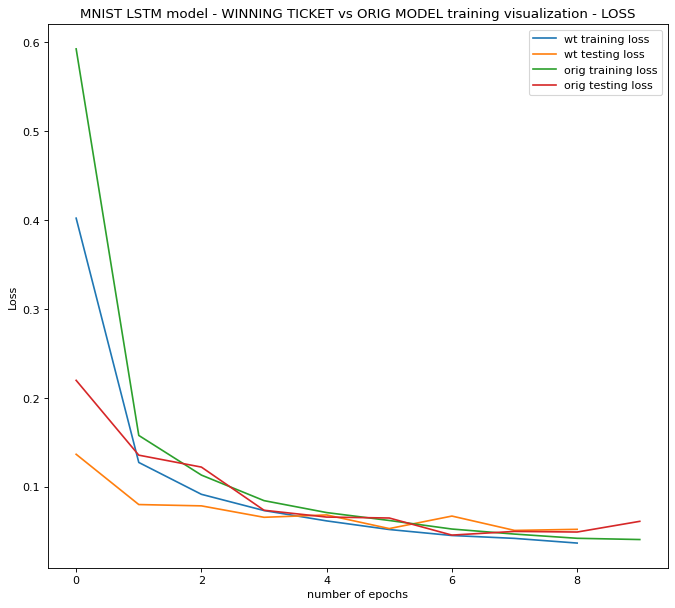

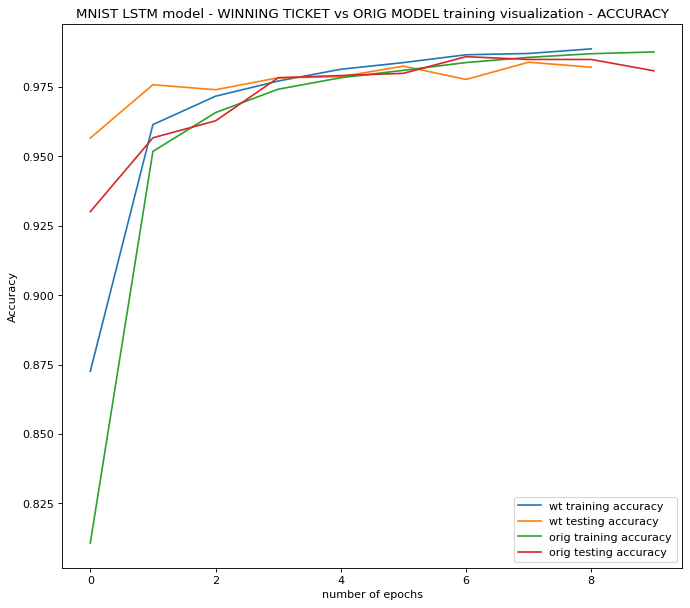

In [ ]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_winning['loss'], label = 'wt training loss')
plt.plot(history_winning['val_loss'], label = 'wt testing loss')
plt.plot(history_orig.history['loss'], label = 'orig training loss')
plt.plot(history_orig.history['val_loss'], label = 'orig testing loss')

plt.title("MNIST LSTM model - WINNING TICKET vs ORIG MODEL training visualization - LOSS")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_winning['accuracy'], label = 'wt training accuracy')
plt.plot(history_winning['val_accuracy'], label = 'wt testing accuracy')
plt.plot(history_orig.history['accuracy'], label = 'orig training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'orig testing accuracy')

plt.title("MNIST LSTM model - WINNING TICKET vs ORIG MODEL training visualization - ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

## RESULT

##### THIS IS ACTUALLY A WINNING TICKET SINCE IT HAS HIGHER ACCURACY IN EARLIER EPOCH!!

#### More Sanity Checks Below

In [ ]:
# Save weights of Winning Ticket (One Shot) trained with GradientTape WITHOUT pruning parameters-
model_gt_stripped.save_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_Trained_GradientTape", overwrite=True)

In [ ]:
# Save weights of Winning Ticket (One Shot) trained with GradientTape WITH pruning parameters-
model_gt.save_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_Trained_GradientTape_Pruning_Parameters", overwrite=True)

In [ ]:
# GradientTape model WITH pruning parameters-
for layer in model_gt.trainable_variables:
    print(layer.shape)

(28, 256)
(64, 256)
(256,)
(64, 10)
(10,)


In [ ]:
print("\nCheck whether weights between 'model_gt' and 'model_gt_stripped' for all layers are same:\n")

for winning_tkt, winning_tkt_pruned in zip(model_gt.trainable_variables, model_gt_stripped.trainable_variables):
    print(np.all(winning_tkt == winning_tkt_pruned))


Check whether weights between 'model_gt' and 'model_gt_stripped' for all layers are same:

True
True
True
True
True


## Additional Experiments

### 7. Random Initial Weights with proper mask

Here we will make experiment to see whether the initial weights are the important factor, as claimed in the paper. 

In [ ]:
# Instantiate a new neural network model for which, the weights are to be extracted

winning_ticket_model_random_w = pruned_nn(pruning_params_unpruned)

In [ ]:
# Load weights of PRUNED model-

winning_ticket_model_random_w.load_weights("ExpLSTM/MNIST_300_100_Weights_Pruned_with_pruning_params")

In [ ]:
# Strip the model of its pruning parameters-

winning_ticket_model_random_w_stripped = sparsity.strip_pruning(winning_ticket_model_random_w)

In [ ]:
# Here we will just initiate a random model to use its weights

random_model=pruned_nn(pruning_params_unpruned)
random_model_stripped=sparsity.strip_pruning(random_model)

In [ ]:
# For each layer, for each weight which is 0, leave it, as is. And for weights which survive the pruning,
# reinitialize it to the value, the model received BEFORE it was trained and pruned-


for rand_wts, pruned_wts in zip(random_model_stripped.trainable_weights, winning_ticket_model_random_w_stripped.trainable_weights):
    pruned_wts.assign(tf.where(tf.equal(pruned_wts, 0), pruned_wts, rand_wts))

### Sanity check

To check of the winning tickets parameters are assigned with the random model and pruned model

In [ ]:
# Sanity check
winning_ticket_model_random_w_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.03403859,  0.02815538,  0.04345867,  0.02383812],
      dtype=float32)>

In [ ]:
#again sanity check with the original model

random_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.07079697,  0.03403859,  0.02815538,  0.04345867,  0.02383812],
      dtype=float32)>

In [ ]:
mask_model_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Save the weights (with pruning parameters) extracted to a file-

winning_ticket_model_random_w_stripped.save_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_Rand_W_One_Shot", overwrite=True)

In [ ]:
#Instantiate a model-
model_gt_random_w = pruned_nn(pruning_params_unpruned)

In [ ]:
model_gt_random_w_stripped=sparsity.strip_pruning(model_gt_random_w)

In [ ]:
# Load weights of winning ticket-
model_gt_random_w_stripped.load_weights("ExpLSTM/MNIST_300_100_Winning_Ticket_Rand_W_One_Shot")

In [ ]:
#sanity check for weights

model_gt_random_w_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.03403859,  0.02815538,  0.04345867,  0.02383812],
      dtype=float32)>

In [ ]:
winning_ticket_model_random_w_stripped.trainable_weights[1][0][:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([-0.        ,  0.03403859,  0.02815538,  0.04345867,  0.02383812],
      dtype=float32)>

In [ ]:
# Dictionary to hold scalar metrics-
epochs=10
history_winning_random_w = {}

history_winning_random_w['accuracy'] = np.zeros(epochs)
history_winning_random_w['val_accuracy'] = np.zeros(epochs)
history_winning_random_w['loss'] = np.zeros(epochs)
history_winning_random_w['val_loss'] = np.zeros(epochs)

## Here I will define the tf.functions again, because otherwise it does not work due to bug

In [ ]:
@tf.function
def train_one_step(model, mask_model, optimizer, x, y):
    '''
    def train_step(data, labels):
    Function to compute one step of gradient descent optimization
    '''
    with tf.GradientTape() as tape:
        # Make predictions using defined model-
        y_pred = model(x)

        # Compute loss-
        loss = loss_fn(y, y_pred)
        
    # Compute gradients wrt defined loss and weights and biases-
    grads = tape.gradient(loss, model.trainable_variables)
    
    # type(grads)
    # list
    
    '''
    for orig_grads, mask in zip(grads, mask_model_stripped.trainable_weights):
        # orig_grads.assign(tf.math.multiply(orig_grads, mask))
        orig_grads = tf.math.multiply(orig_grads, mask)
    '''
    
    # THIS IS CORRECT-
    # List to hold element-wise multiplication between-
    # computed gradient and masks-
    grad_mask_mul = []
    
    # Perform element-wise multiplication between computed gradients and masks-
    for grad_layer, mask in zip(grads, mask_model.trainable_weights):
        grad_mask_mul.append(tf.math.multiply(grad_layer, mask))
    
    # Apply computed gradients to model's weights and biases-
    # optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # normally we just apply the grads but here we use masked grads
    optimizer.apply_gradients(zip(grad_mask_mul, model.trainable_variables))

    # Compute accuracy-
    train_loss(loss)
    train_accuracy(y, y_pred)

    # return model_loss
    # return None


In [ ]:
@tf.function
def test_step(model, optimizer, data, labels):
    """
    Function to test model performance
    on testing dataset
    """
    
    predictions = model(data)
    t_loss = loss_fn(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


In [ ]:
#min_loss and patience_sofar is the variables to manually enable early stopping  

min_loss=10
patience_sofar=0

for epoch in range(10):
    
    #to stop training when earlystopping criterion met
    if patience_sofar >= patience:
        print("\n\nEarlyStopping Evoked! Stopping training\n\n")
        break
    
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for x, y in train_dataset:
        train_one_step(model_gt_random_w_stripped, mask_model_stripped, optimizer, x, y)
        

    for x_t, y_t in test_dataset:
        
        test_step(model_gt_random_w_stripped, optimizer, x_t, y_t)

    template = 'Epoch {0}, Loss: {1:.4f}, Accuracy: {2:.4f}, Test Loss: {3:.4f}, Test Accuracy: {4:4f}'

    history_winning_random_w['accuracy'][epoch] = train_accuracy.result()
    history_winning_random_w['loss'][epoch] = train_loss.result()
    history_winning_random_w['val_loss'][epoch] = test_loss.result()
    history_winning_random_w['val_accuracy'][epoch] = test_accuracy.result()

    print(template.format(epoch + 1, 
                          train_loss.result(), train_accuracy.result()*100,
                          test_loss.result(), test_accuracy.result()*100))
    
    # Count number of non-zero parameters in each layer and in total-

    model_sum_params = 0
    
    for layer in model_gt_random_w_stripped.trainable_weights:
        
        model_sum_params += tf.math.count_nonzero(layer, axis = None).numpy()
    
    print("Total number of trainable parameters = {0}\n".format(model_sum_params))

    #for computing the early stopping manually
    
    if (min_loss-history_winning_random_w['val_loss'][epoch])>minimum_delta:
        min_loss=history_winning_random_w['val_loss'][epoch]
    else:
        patience_sofar+=1
    
            

Epoch 1, Loss: 0.5141, Accuracy: 83.2033, Test Loss: 0.1502, Test Accuracy: 95.240005
Total number of trainable parameters = 17201

Epoch 2, Loss: 0.1510, Accuracy: 95.4533, Test Loss: 0.0982, Test Accuracy: 96.910004
Total number of trainable parameters = 17201

Epoch 3, Loss: 0.1020, Accuracy: 96.9367, Test Loss: 0.1278, Test Accuracy: 95.910004
Total number of trainable parameters = 17201

Epoch 4, Loss: 0.0850, Accuracy: 97.3833, Test Loss: 0.0768, Test Accuracy: 97.539993
Total number of trainable parameters = 17201

Epoch 5, Loss: 0.0736, Accuracy: 97.7533, Test Loss: 0.0589, Test Accuracy: 98.229996
Total number of trainable parameters = 17201

Epoch 6, Loss: 0.0618, Accuracy: 98.1200, Test Loss: 0.0547, Test Accuracy: 98.409996
Total number of trainable parameters = 17201

Epoch 7, Loss: 0.0554, Accuracy: 98.3067, Test Loss: 0.0652, Test Accuracy: 98.110001
Total number of trainable parameters = 17201

Epoch 8, Loss: 0.0507, Accuracy: 98.4200, Test Loss: 0.0506, Test Accuracy: 

In [ ]:
#test accuracy of random weights winning ticket

test_accuracy.reset_states()
test_step(model_gt_random_w_stripped,optimizer,x_test,y_test)
score_winning=test_accuracy.result()
print(score_winning)

tf.Tensor(0.987, shape=(), dtype=float32)


In [ ]:
#to clear the zero values from dictionary to have better visualization

for k,v in history_winning_random_w.items():
    history_winning_random_w[k]=np.where(v==0,np.nan,v)

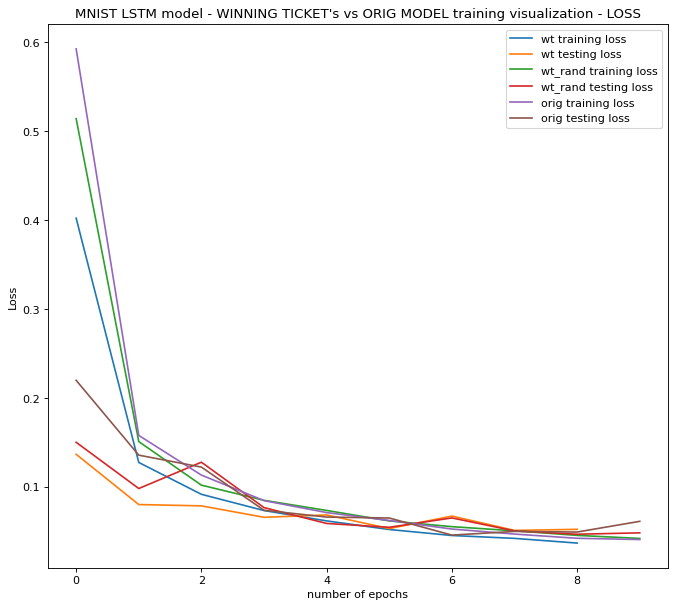

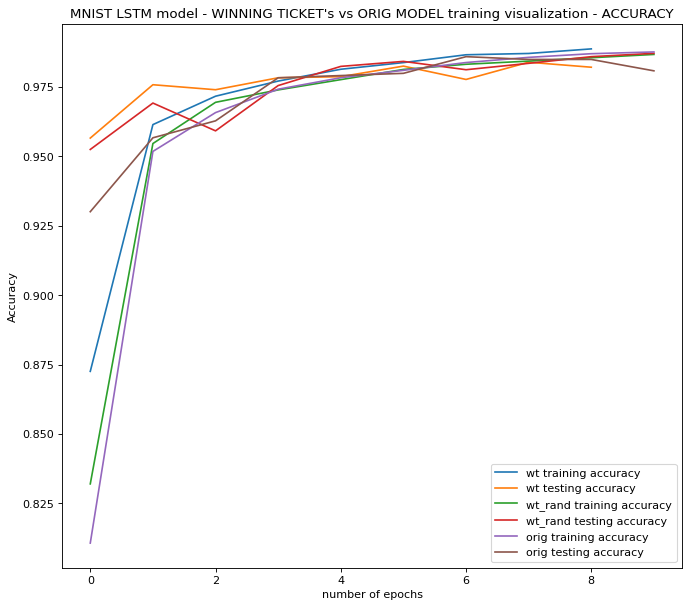

In [ ]:
# Visualize neural network which is to be pruned off-
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_winning['loss'], label = 'wt training loss')
plt.plot(history_winning['val_loss'], label = 'wt testing loss')
plt.plot(history_winning_random_w['loss'], label = 'wt_rand training loss')
plt.plot(history_winning_random_w['val_loss'], label = 'wt_rand testing loss')
plt.plot(history_orig.history['loss'], label = 'orig training loss')
plt.plot(history_orig.history['val_loss'], label = 'orig testing loss')


plt.title("MNIST LSTM model - WINNING TICKET's vs ORIG MODEL training visualization - LOSS")
plt.ylabel("Loss")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(history_winning['accuracy'], label = 'wt training accuracy')
plt.plot(history_winning['val_accuracy'], label = 'wt testing accuracy')
plt.plot(history_winning_random_w['accuracy'], label = 'wt_rand training accuracy')
plt.plot(history_winning_random_w['val_accuracy'], label = 'wt_rand testing accuracy')
plt.plot(history_orig.history['accuracy'], label = 'orig training accuracy')
plt.plot(history_orig.history['val_accuracy'], label = 'orig testing accuracy')

plt.title("MNIST LSTM model - WINNING TICKET's vs ORIG MODEL training visualization - ACCURACY")
plt.ylabel("Accuracy")
plt.xlabel("number of epochs")
plt.legend(loc = 'best')
plt.show()

### Observation

Here we dont observe any particular difference with random initialization and original initialization.

However, we have used _one shot_ approach while the study suggested _iterative_ pruning